# Motif Matches With Known Motifs

TODO:
- compare matched motifs vs information content & influence
- get TomTom motif matches for all sets

In [12]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, Dense, Activation, Dropout, MaxPooling1D, Flatten, \
    GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
reload(nn_utils)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

import cPickle
import draw_logo

## Loading TomTom Results

These are the results for model 2017-01-13, which is the convolutional-2maxpool-dense model with 200 filters.

In [2]:
tomtom = pd.read_table('./2017-01-13-motifs/tomtom.txt')

In [3]:
tomtom.head()

#Query ID  Target ID  Optimal offset   p-value   E-value  q-value  Overlap  \
0          0  UP00216_1               1  0.000380  0.544753      1.0        6   
1          0  UP00098_1              12  0.002188  3.137130      1.0        6   
2          0   MA0035.3               5  0.004557  6.534860      1.0        6   
3          0   MA0122.1               1  0.005122  7.344900      1.0        6   
4          1   MA0035.3               5  0.000986  1.414370      1.0        6   

  Query consensus         Target consensus Orientation  
0          TAAGGG        TTAAGGGGATTAACTAC           +  
1          TAAGGG  TTAATCGGTTGCTAAGGGTCACA           -  
2          TAAGGG              ACAGATAAGAA           -  
3          TAAGGG                TTAAGTGGA           +  
4          TAAGAA              ACAGATAAGAA           -

In [20]:
# negative orientation things are wrong because... this is mRNA, we only have a forward strand
tomtom = tomtom[tomtom.Orientation=='+']

In [4]:
avg_filters = np.load('../data/2017-01-13-filters.npy')

In [5]:
influences = np.load('../data/2017-01-13-influence.npy')

## Analysis of TomTom results

- compare the number of query hits to the information content of each filter
- compare the E-values to the information content

In [32]:
query_hits = [sum(tomtom['#Query ID']==i) for i in range(200)]
min_eval = [min(tomtom['E-value'][tomtom['#Query ID']==i].tolist() + [100]) for i in range(200)]

In [33]:
info = []
for i in range(200):
    info.append(6*2.0 - sum(draw_logo.entropy(avg_filters[i][j,:] for j in range(6))))

In [34]:
filter_data = pd.DataFrame({'influence': influences, 'information': info,
                            'tomtom_hits': query_hits, 'min_eval': min_eval})

In [35]:
filter_data.head()

influence  information  min_eval  tomtom_hits
0   2.217329     3.689959  0.544753            2
1   3.284102     2.725705  2.827340            3
2   7.074416     2.696651  5.842940            2
3   3.410780     2.845392  4.363180            3
4   3.332547     3.271668  5.045110            3

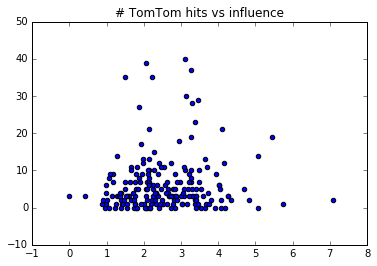

In [24]:
plt.scatter(filter_data.influence, filter_data.tomtom_hits)
plt.title('# TomTom hits vs influence')

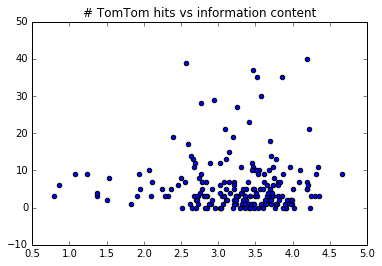

In [25]:
plt.scatter(filter_data.information, filter_data.tomtom_hits)
plt.title('# TomTom hits vs information content')

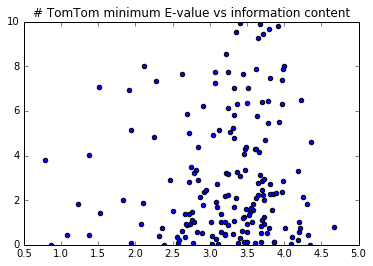

In [44]:
plt.scatter(filter_data.information, filter_data.min_eval)
plt.ylim(0, 10)
plt.title('# TomTom minimum E-value vs information content')

In [43]:
tomtom.loc[tomtom['E-value'].argmin()]

#Query ID                    44
Target ID              MA0467.1
Optimal offset                1
p-value             2.05283e-07
E-value             0.000294376
q-value             0.000588753
Overlap                       6
Query consensus          AGAGGA
Target consensus    AAGAGGATTAG
Orientation                   +
Name: 423, dtype: object

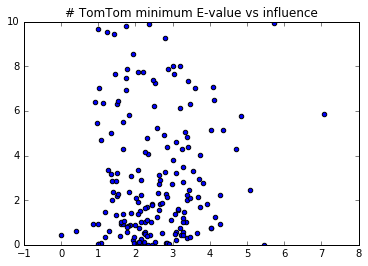

In [45]:
plt.scatter(filter_data.influence, filter_data.min_eval)
plt.ylim(0, 10)
plt.title('# TomTom minimum E-value vs influence')

Notes:

There aren't many convincing matches with known motifs in the JASPAR database. This could be because the motifs in the database are usually *DNA motifs*, while splicing might be more often affected by *RNA-binding proteins*.

TODO:

- look for RNA-binding motif databases
- try out some new neural networks
- neural networks to try: two conv layers, using both alt exon + alt intron regions